# Parabolic SAR

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns

import yfinance as yf
yf.pdr_override()

In [2]:
# input
symbol = 'AAPL'
start = '2018-08-01'
end = '2019-01-01'

# Read data 
df = yf.download(symbol,start,end)

# View Columns
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-08-01,49.782501,50.439999,49.327499,50.375000,48.208729,271742800
2018-08-02,50.145000,52.095001,50.087502,51.847500,49.617920,249616000
2018-08-03,51.757500,52.185001,51.369999,51.997501,49.761459,133789600
2018-08-06,52.000000,52.312500,51.767502,52.267502,50.019848,101701600
2018-08-07,52.330002,52.375000,51.689999,51.777500,49.550922,102349600


In [3]:
def parabolic_sar(high, low, acceleration_factor=0.02, max_acceleration_factor=0.2):
    # Initialize variables
    sar = low[0]
    ep = high[0]
    af = acceleration_factor
    trend = 1
    sar_list = [sar]

    # Loop through each data point
    for i in range(1, len(high)):
        if trend == 1:
            if low[i] < sar:
                trend = -1
                sar = ep
                ep = high[i]
                af = acceleration_factor
            else:
                sar = sar + af * (ep - sar)
                if high[i] > ep:
                    ep = high[i]
                    af = min(af + acceleration_factor, max_acceleration_factor)
        else:
            if high[i] > sar:
                trend = 1
                sar = ep
                ep = low[i]
                af = acceleration_factor
            else:
                sar = sar - af * (sar - ep)
                if low[i] < ep:
                    ep = low[i]
                    af = min(af + acceleration_factor, max_acceleration_factor)
        sar_list.append(sar)

    return pd.Series(sar_list, index=high.index)


In [4]:
high = df['High']
low = df['Low']

sar = parabolic_sar(high, low)
df['SAR'] = sar

In [5]:
df = df.dropna()
df.head()

,Open,High,Low,Close,Adj Close,Volume,SAR
Date,,,,,,,
2018-08-01,49.782501,50.439999,49.327499,50.375000,48.208729,271742800,49.327499
2018-08-02,50.145000,52.095001,50.087502,51.847500,49.617920,249616000,49.349749
2018-08-03,51.757500,52.185001,51.369999,51.997501,49.761459,133789600,49.459559
2018-08-06,52.000000,52.312500,51.767502,52.267502,50.019848,101701600,49.623086
2018-08-07,52.330002,52.375000,51.689999,51.777500,49.550922,102349600,49.838239


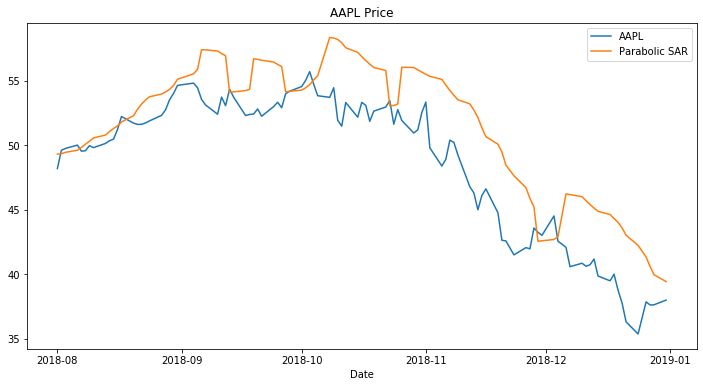

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(df['Adj Close'], label=symbol)
plt.plot(df['SAR'], label='Parabolic SAR')
plt.title(symbol + ' Price')
plt.xlabel('Date')
plt.legend()
plt.show()

## Candlestick with Parabolic SAR

In [7]:
from matplotlib import dates as mdates
import datetime as dt

dfc = df.copy()
dfc['VolumePositive'] = dfc['Open'] < dfc['Adj Close']
#dfc = dfc.dropna()
dfc = dfc.reset_index()
dfc['Date'] = pd.to_datetime(dfc['Date'])
dfc['Date'] = dfc['Date'].apply(mdates.date2num)
dfc.head()

,Date,Open,High,Low,Close,Adj Close,Volume,SAR,VolumePositive
0,736907.0,49.782501,50.439999,49.327499,50.375000,48.208729,271742800,49.327499,False
1,736908.0,50.145000,52.095001,50.087502,51.847500,49.617920,249616000,49.349749,False
2,736909.0,51.757500,52.185001,51.369999,51.997501,49.761459,133789600,49.459559,False
3,736912.0,52.000000,52.312500,51.767502,52.267502,50.019848,101701600,49.623086,False
4,736913.0,52.330002,52.375000,51.689999,51.777500,49.550922,102349600,49.838239,False


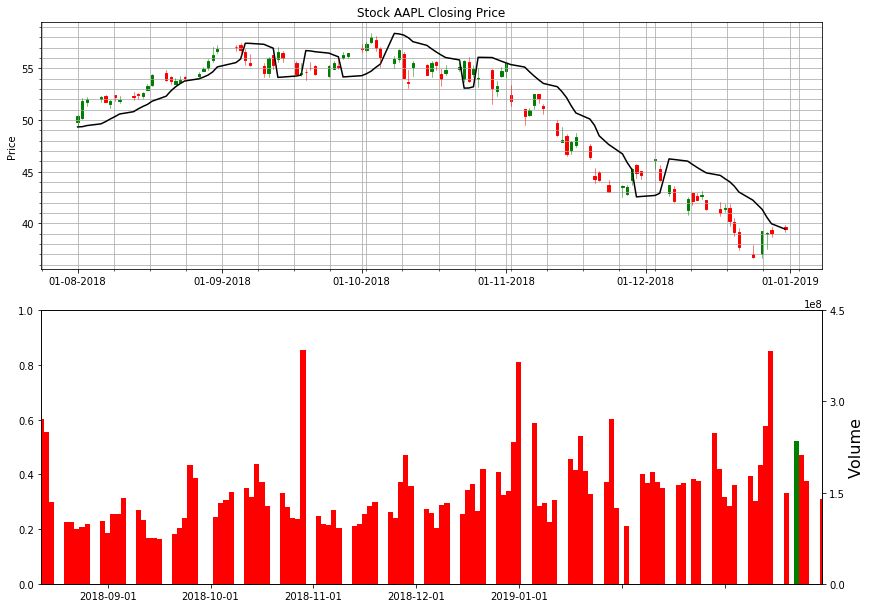

In [14]:
from mplfinance.original_flavor import candlestick_ohlc
import datetime
from matplotlib.dates import num2date

fig = plt.figure(figsize=(14,10))
ax1 = plt.subplot(2, 1, 1)
ax1.plot(df['SAR'], label='Parabolic SAR', color='k')
candlesticks=candlestick_ohlc(ax1,dfc.values, width=0.5, colorup='g', colordown='r', alpha=1.0)
ax1.xaxis_date()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax1.grid(True, which='both')
ax1.minorticks_on()
ax1.set_title('Stock '+ symbol +' Closing Price')
ax1.set_ylabel('Price')

# create the second axis for the volume bar-plot
ax2 = plt.subplot(2, 1, 2)
ax2 = ax2.twinx()

# set the position of ax2 so that it is short (y2=0.32) but otherwise the same size as ax
ax2.set_position(matplotlib.transforms.Bbox([[0.125,0.1],[0.9,0.48]]))

# get data from candlesticks for a bar plot
dates = [x[0] for x in candlesticks]
dates = np.asarray(dates)
volume = [x[5] for x in candlesticks]
volume = np.asarray(volume)

# make bar plots and color differently depending on up/down for the day
pos = dfc['Open']-dfc['Adj Close']<0
neg = dfc['Open']-dfc['Adj Close']>0
ax2.bar(dfc.Date[pos],dfc.Volume[pos],color='green',width=1,align='center')
ax2.bar(dfc.Date[neg],dfc.Volume[neg],color='red',width=1,align='center')

#scale the x-axis tight
ax2.set_xlim(min(dfc.Date),max(dfc.Date))
# the y-ticks for the bar were too dense, keep only every third one
yticks = ax2.get_yticks()
ax2.set_yticks(yticks[::3])

ax2.yaxis.set_label_position("right")
ax2.set_ylabel('Volume', size=16)

# format the x-ticks with a human-readable date. 
xt = ax1.get_xticks()
new_xticks = [datetime.date.isoformat(num2date(d)) for d in xt]
ax2.set_xticklabels(new_xticks, horizontalalignment='right')
plt.show()